# sign language recgnization with pytorch

##### in this project we want to build a model which recognizes the sign language from hand gestures using pytorch and resNet18

### importing libraries

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

### american sign language 

##### data set includes images of american sign language hand gestures which are in grayscale

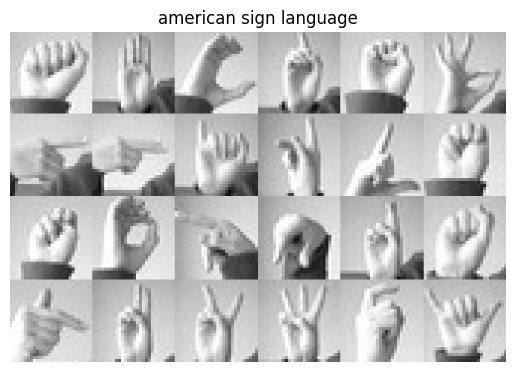

In [2]:
dataset_image_path = "amer_sign3.png"
img = Image.open(dataset_image_path)
    
plt.imshow(img)
plt.title("american sign language")
plt.axis('off')
plt.show()

In [3]:
#loading the dataset from csv files
train_df = pd.read_csv("./sign_mnist_train/sign_mnist_train.csv")

test_temp_df = pd.read_csv("./sign_mnist_test/sign_mnist_test.csv")

validation_df, test_df = train_test_split(test_temp_df, test_size=0.5, random_state=42, stratify=test_temp_df['label'])

#number of classes
alphabet_num = train_df["label"].nunique()

#number of train,test,validation data
train_num = train_df.shape[0]
test_num = test_df.shape[0]
val_num = validation_df.shape[0]

print(f"Training samples: {train_num}")
print(f"Test samples: {test_num}")
print(f"val samples: {val_num}")
print(f"Number of classes: {alphabet_num}")


Training samples: 27455
Test samples: 3586
val samples: 3586
Number of classes: 24


#### showing some random samples of the trainig set



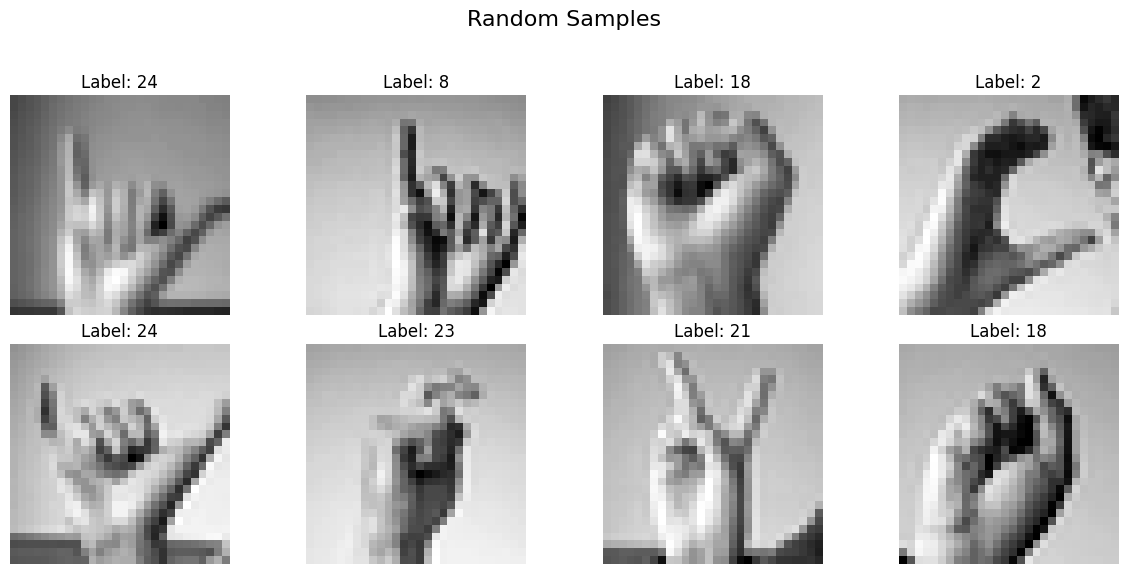

In [4]:
def display_random_samples(dataframe, n_samples=8, cols=4, title="Random Samples"):
    
    rows = (n_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    
    if rows == 1:
        axes = np.array([axes])
        
    random_samples = dataframe.sample(n=n_samples, random_state=42)
    
    for i, ax in enumerate(axes.flatten()):
        if i < n_samples:
            sample_row = random_samples.iloc[i]
            label = sample_row.iloc[0]
            pixels = sample_row.iloc[1:].values
            image = pixels.reshape(28, 28)
            
            ax.imshow(image, cmap='gray')
            ax.set_title(f"Label: {label}")
            ax.axis('off')
        else:
            ax.axis('off')
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

display_random_samples(train_df, n_samples=8)

### Define dataset class

In [5]:
# Define the custom Dataset class
class SignLanguageMNIST(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = self.df['label'].values
        self.labels[self.labels > 9] -= 1
        self.images = self.df.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image, mode='L')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations and data augmatations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
eval_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = SignLanguageMNIST(train_df, transform=train_transform)
validation_dataset = SignLanguageMNIST(validation_df, transform=eval_transform)
test_dataset = SignLanguageMNIST(test_df, transform=eval_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### loading the model

In [33]:
# Load ResNet-18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Count feature and classifier layers
feature_layers = 0
classifier_layers = 0
for name, child in model.named_children():
    if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']:
        feature_layers += 1
    elif name == 'fc':
        classifier_layers += 1
print("before freezing")
print(f"Total Feature Layers: {feature_layers}")
print(f"Total Classifier Layers: {classifier_layers}")

# fine tunning
for name, child in model.named_children():
    if name in ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']:
        for param in child.parameters():
            param.requires_grad = False
num_classes = 24
model.fc = nn.Linear(model.fc.in_features, num_classes)
print("after freezing")
print("--- Trainable vs. Frozen Layers ---")
for name, param in model.named_parameters():
    print(f"Layer: {name:<25} | Trainable: {param.requires_grad}")
print("-----------------------------------")

before freezing
Total Feature Layers: 9
Total Classifier Layers: 1
after freezing
--- Trainable vs. Frozen Layers ---
Layer: conv1.weight              | Trainable: False
Layer: bn1.weight                | Trainable: False
Layer: bn1.bias                  | Trainable: False
Layer: layer1.0.conv1.weight     | Trainable: False
Layer: layer1.0.bn1.weight       | Trainable: False
Layer: layer1.0.bn1.bias         | Trainable: False
Layer: layer1.0.conv2.weight     | Trainable: False
Layer: layer1.0.bn2.weight       | Trainable: False
Layer: layer1.0.bn2.bias         | Trainable: False
Layer: layer1.1.conv1.weight     | Trainable: False
Layer: layer1.1.bn1.weight       | Trainable: False
Layer: layer1.1.bn1.bias         | Trainable: False
Layer: layer1.1.conv2.weight     | Trainable: False
Layer: layer1.1.bn2.weight       | Trainable: False
Layer: layer1.1.bn2.bias         | Trainable: False
Layer: layer2.0.conv1.weight     | Trainable: False
Layer: layer2.0.bn1.weight       | Trainable: Fals

In [36]:
# Define device, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
criterion = nn.CrossEntropyLoss()
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=0.001)

print("Model Summary:")
summary(model, input_size=(3, 224, 224))

Using device: cuda
Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
     

### training the model

In [7]:
# train_model function
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs):
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0
        with tqdm(train_loader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                tepoch.set_postfix(loss=loss.item())

        train_loss = train_running_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(validation_loader)
        val_accuracy = 100 * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
    return history

# Train the model
num_epochs = 5
history = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=num_epochs)



Epoch 1: 100%|██████████| 858/858 [03:08<00:00,  4.56batch/s, loss=0.0463] 


Epoch 1/5, Train Loss: 0.2328, Train Accuracy: 92.65%, Validation Loss: 0.0765, Validation Accuracy: 97.02%


Epoch 2: 100%|██████████| 858/858 [03:26<00:00,  4.15batch/s, loss=0.0199]  


Epoch 2/5, Train Loss: 0.0598, Train Accuracy: 98.18%, Validation Loss: 0.1048, Validation Accuracy: 97.24%


Epoch 3: 100%|██████████| 858/858 [03:08<00:00,  4.55batch/s, loss=0.232]   


Epoch 3/5, Train Loss: 0.0462, Train Accuracy: 98.61%, Validation Loss: 0.0208, Validation Accuracy: 99.16%


Epoch 4: 100%|██████████| 858/858 [03:33<00:00,  4.03batch/s, loss=0.219]   


Epoch 4/5, Train Loss: 0.0394, Train Accuracy: 98.78%, Validation Loss: 0.0287, Validation Accuracy: 99.27%


Epoch 5: 100%|██████████| 858/858 [03:48<00:00,  3.75batch/s, loss=0.00341] 


Epoch 5/5, Train Loss: 0.0318, Train Accuracy: 98.99%, Validation Loss: 0.0158, Validation Accuracy: 99.30%


### plotting results

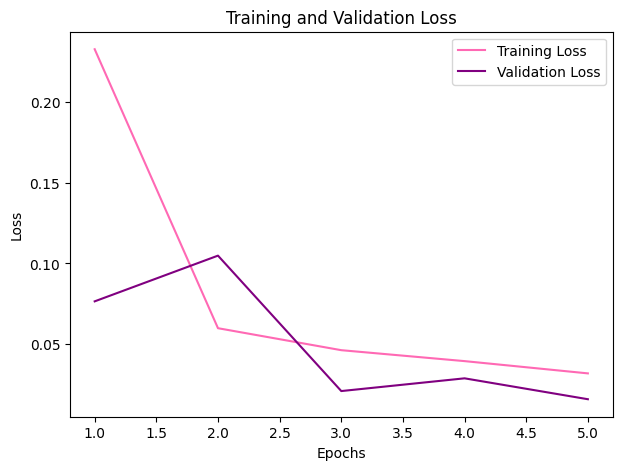

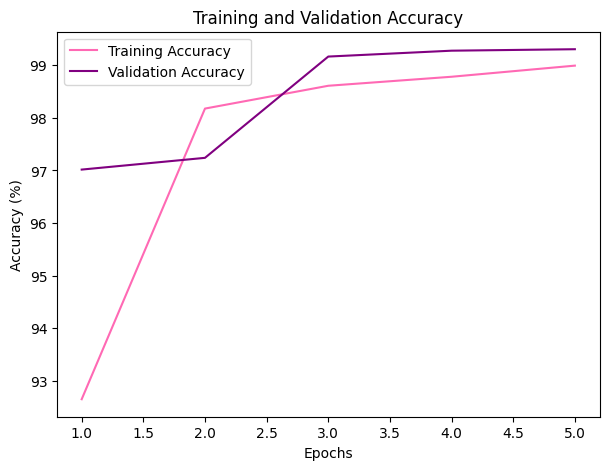

In [35]:
# Plotting the results
epochs = range(1, num_epochs + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(epochs, history['train_loss'], color='hotpink', linestyle='-', label='Training Loss')
plt.plot(epochs, history['val_loss'], color='purple', linestyle='-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot_pink_purple.png')
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(epochs, history['train_accuracy'], color='hotpink', linestyle='-', label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], color='purple', linestyle='-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('accuracy_plot_pink_purple.png')
plt.show()

Accuracy on test set: 99.14%
F1-Score on test set: 0.9912


<Figure size 1200x1200 with 0 Axes>

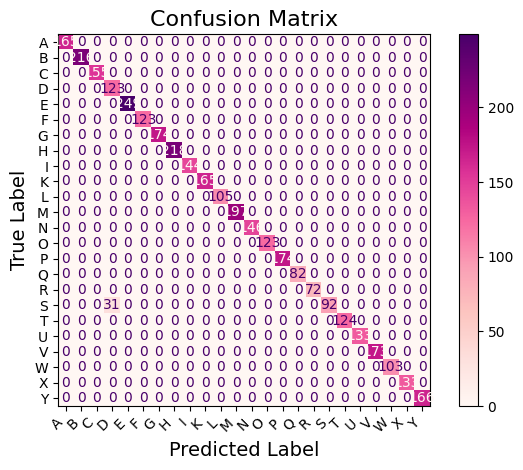

<Figure size 640x480 with 0 Axes>

In [30]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * (sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels))
    print(f"Accuracy on test set: {accuracy:.2f}%")

    # Calculate F1-Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"F1-Score on test set: {f1:.4f}")

    # Confusion Matrix 
    cm = confusion_matrix(all_labels, all_predictions)
    disp_labels = [chr(ord('A')+i) for i in range(25) if i != 9]

    plt.figure(figsize=(12, 12)) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)
    disp.plot(cmap=plt.cm.RdPu) 
    plt.title('Confusion Matrix', fontsize=16) 
    plt.xlabel('Predicted Label', fontsize=14) 
    plt.ylabel('True Label', fontsize=14) 
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()
    plt.savefig('confusion_matrix_pink_purple_large.png')

evaluate_model(model, test_loader)